In [ ]:
import numpy as np
import pandas as pd
import pathlib
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir='/content/drive/MyDrive/skin disease/skin-disease-seperated/train'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/skin disease/skin-disease-seperated/train')

In [ ]:
Acne= list(data_dir.glob('Acne/*')) #840 - 252
Eczema= list(data_dir.glob('Eczema/*')) #1677 - 503
Psoriasis= list(data_dir.glob('Psoriasis_and_LP/*')) #1405 - 421
Ringworm= list(data_dir.glob('Ringworm/*')) #1300 - 390

In [ ]:
# Contains the images path
df_images = {
'Acne':Acne,
'Eczema':Eczema,
'Psoriasis':Psoriasis,
'Ringworm':Ringworm,
}

# Contains numerical labels for the categories
df_labels = {
'Acne':0,
'Eczema':1,
'Psoriasis':2,
'Ringworm':3,
}

In [ ]:
import cv2 as cv
X=[]
y=[]
for label, images in df_images.items():
    for image in images:    
        img=cv.imread(str(image))
        img=cv.resize(img,(224,224))
        img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
        X.append(img)
        y.append(df_labels[label])

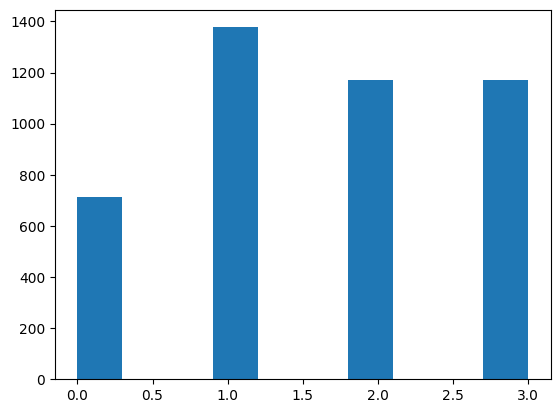

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y)
plt.show()

In [ ]:
data_dir='/content/drive/MyDrive/skin disease/skin-disease-seperated/test'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/skin disease/skin-disease-seperated/test')

In [ ]:
Acne= list(data_dir.glob('Acne/*')) #840
Eczema= list(data_dir.glob('Eczema/*')) #1677
Psoriasis= list(data_dir.glob('Psoriasis_and_LP/*')) #1405
Ringworm= list(data_dir.glob('Ringworm/*')) #1300

In [ ]:
# Contains the images path
df_images = {
'Acne':Acne,
'Eczema':Eczema,
'Psoriasis':Psoriasis,
'Ringworm':Ringworm,
}

# Contains numerical labels for the categories
df_labels = {
'Acne':0,
'Eczema':1,
'Psoriasis':2,
'Ringworm':3,
}

In [ ]:
import cv2 as cv
X_test=[]
y_test=[]
for label, images in df_images.items():
    for image in images:
        img=cv.imread(str(image))
        img=cv.resize(img,(224,224))
        img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
        X_test.append(img)
        y_test.append(df_labels[label])

In [ ]:
import cv2
import numpy as np

# Define the preprocessing functions
def contours(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (0,255,0), 3)
    return image

In [ ]:
X_train_contours = []
for image in X:
    preprocessed_image = image.copy()
    preprocessed_image = contours(preprocessed_image)
    X_train_contours.append(preprocessed_image)

In [ ]:
X_test_contours = []
for image in X_test:
    preprocessed_image = image.copy()
    preprocessed_image = contours(preprocessed_image)
    X_test_contours.append(preprocessed_image)

In [ ]:
import matplotlib.pyplot as plt

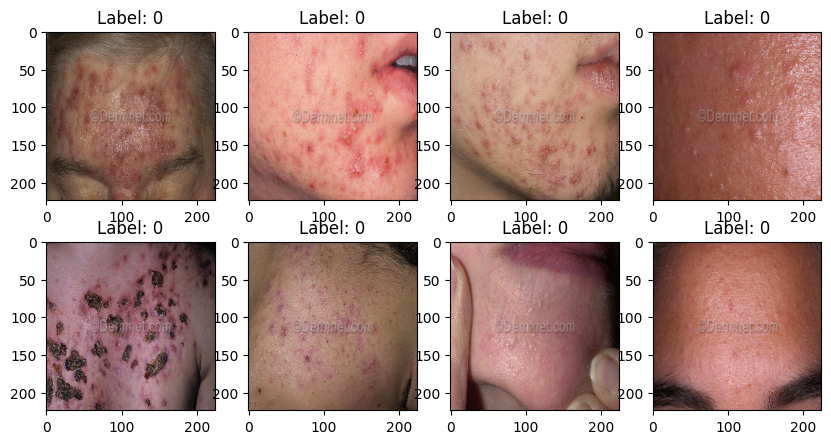

In [ ]:
# Display the first 8 images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i])
    ax.set_title(f"Label: {y[i]}")
plt.show()

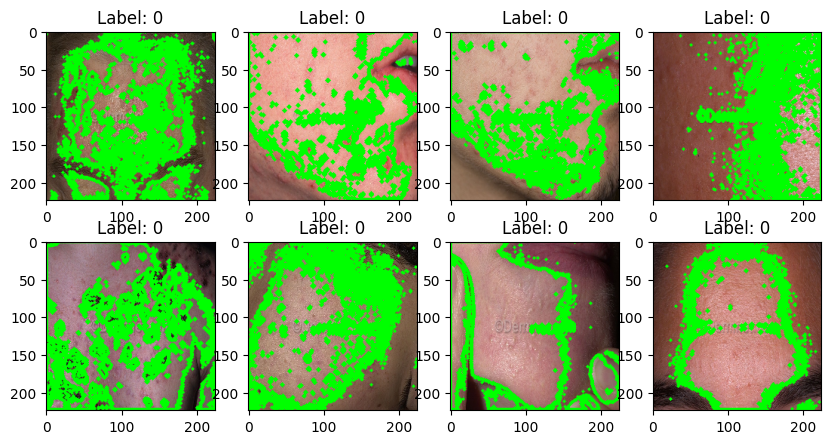

In [ ]:
# Display the first 8 images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_contours[i])
    ax.set_title(f"Label: {y[i]}")
plt.show()

In [ ]:
X_train = np.array(X)
X_test = np.array(X_test)
y_train = np.array(y)
y_test = np.array(y_test)
X_train_contours = np.array(X_train_contours)
X_test_contours= np.array(X_test_contours)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train_contours.shape)

(4434, 224, 224, 3)
(1889, 224, 224, 3)
(4434,)
(1889,)
(4434, 224, 224, 3)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
efficientnet_x = Flatten()(efficientnet_model.output)
efficientnet_output = Dense(4, activation='softmax')(efficientnet_x)
efficientnet_model = Model(inputs=efficientnet_model.input, outputs=efficientnet_output)

In [ ]:
efficientnet_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=1)

In [ ]:
efficientnet_history1 = efficientnet_model.fit(X_train_contours, y_train, validation_data=(X_test_contours, y_test), epochs=25, batch_size=32, callbacks=[early_stop])

Epoch 1/25
139/139 [==============================] - 42s 303ms/step - loss: 0.3254 - accuracy: 0.9592 - val_loss: 3.6506 - val_accuracy: 0.8089
Epoch 2/25
139/139 [==============================] - 39s 282ms/step - loss: 0.3762 - accuracy: 0.9630 - val_loss: 3.6713 - val_accuracy: 0.7946


In [ ]:
from sklearn.metrics import accuracy_score
y_pred=efficientnet_model.predict(X_test).argmax(axis=1)

60/60 [==============================] - 3s 55ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
accuracy

0.7448385389094759

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

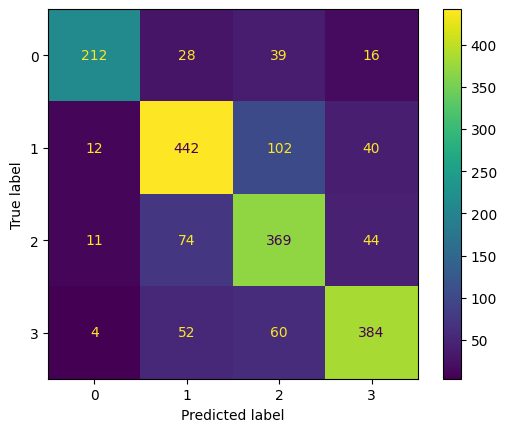

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.79       295
           1       0.74      0.74      0.74       596
           2       0.65      0.74      0.69       498
           3       0.79      0.77      0.78       500

    accuracy                           0.74      1889
   macro avg       0.77      0.74      0.75      1889
weighted avg       0.75      0.74      0.75      1889



In [ ]:
efficientnet_model.save('IPDFINAL.h5')

TypeError: ignored

In [ ]:
!pip install --upgrade keras==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.10.0 which is incompatible.


In [ ]:
import keras